<a href="https://colab.research.google.com/github/unique-subedi/gene-expression/blob/main/Ahn_gene_expression_master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import datetime
import time
import math
import numpy as np
from numpy import linalg as LA
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request

In [2]:
!pip install pyreadr
import pyreadr
urllib.request.urlretrieve("https://raw.githubusercontent.com/unique-subedi/gene-expression/main/data/brain.rda", "brain.rda")
brain = pyreadr.read_r("brain.rda")

expression = pd.DataFrame(brain["expression"])
genes = pd.DataFrame(brain["genes"])
samples = pd.DataFrame(brain["samples"])

# Control genes starting with AFFX
genes_c = genes.filter(regex='AFFX', axis=0)

# Select bacterial controls
genes.at["AFFX-BioDn-3_at", 'chrom'] = float("Nan")
genes_control = genes[['AFFX' in s for s in genes.index]]
genes_control = genes_control[['HUM' not in s for s in genes_control.index]]
genes_control = genes_control[['hum' not in s for s in genes_control.index]]
genes_bac_index = genes_control[genes_control.chrom.isnull() & genes_control.sym.isnull()].index

# Microarray level Normalization: Detected microarray-wise effects for both michigan and irvine
# We ideally want very similar distribution(mean, std) for each microarray. 
# This does not remove lab effects/heterogeneity across labs
mean_bac_exp = expression[genes_bac_index].mean(axis=1)
std_bac_exp = expression[genes_bac_index].std(axis=1)
expression_norm =  (expression - mean_bac_exp.values[:, None]).divide(std_bac_exp, axis=0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 363 kB 2.5 MB/s 


# Data Preparation

`michigan` dataset contains the measurements, done at University of Michigan lab, of anterior cortex and dorsolateral cortex for each patient. 

`michigan_diff` subtracts measurement of anterior cortex from the dorsolateral cortex for each patient.

In [3]:
# Michigan
michigan = expression_norm[(expression.index.str[5] == 'M') & (expression.index.str[3] != 'c') ]
michigan_diff = michigan.diff().iloc[1::2,:]
michigan_diff.index = "patient" + michigan_diff.index.str[:2]
#michigan_diff

# Davis
davis = expression_norm[(expression.index.str[5] == 'D') & (expression.index.str[3] != 'c') ]
davis = davis[~davis.index.str[1].isin(['1', '2', '5', '6', '7', '9'])]
#davis

# Irvine
irvine = expression_norm[(expression.index.str[5] == 'I') & (expression.index.str[3] != 'c') ]
irvine_diff = irvine.diff().iloc[1::2,:]
irvine_diff.index = "patient" + irvine_diff.index.str[:2]
#irvine_diff

In [ ]:
'''
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan.T)

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine.T)
'''

'\nplt.figure(figsize=(20, 8))\nplt.grid()\nsns.boxplot(data=michigan.T)\n\nplt.figure(figsize=(20, 8))\nplt.grid()\nsns.boxplot(data=irvine.T)\n'

In [ ]:
# Plot bacterial controls:
'''
Michigan: has lower expression than Irvine with higher standard deviation
Irvine: 02_d_I_m_2.CEL and 06_d_I_m_2.CEL(3, 11) generally have higher gene expression
We might want to adjust microarray-wise first and then do lab-wise adjustment
'''

'''
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan[genes_bac_index])

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine[genes_bac_index])
'''

'\nplt.figure(figsize=(20, 8))\nplt.grid()\nsns.boxplot(data=michigan[genes_bac_index])\n\nplt.figure(figsize=(20, 8))\nplt.grid()\nsns.boxplot(data=irvine[genes_bac_index])\n'

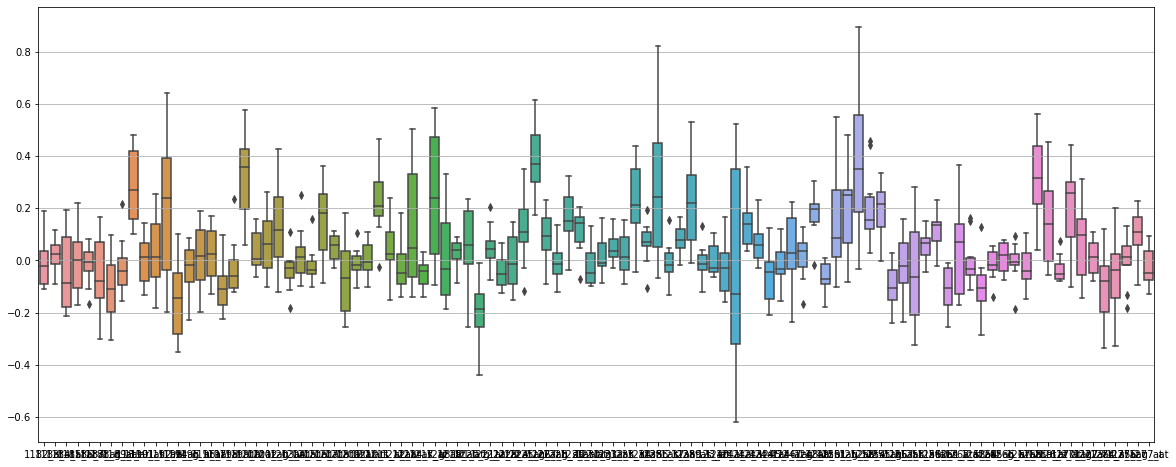

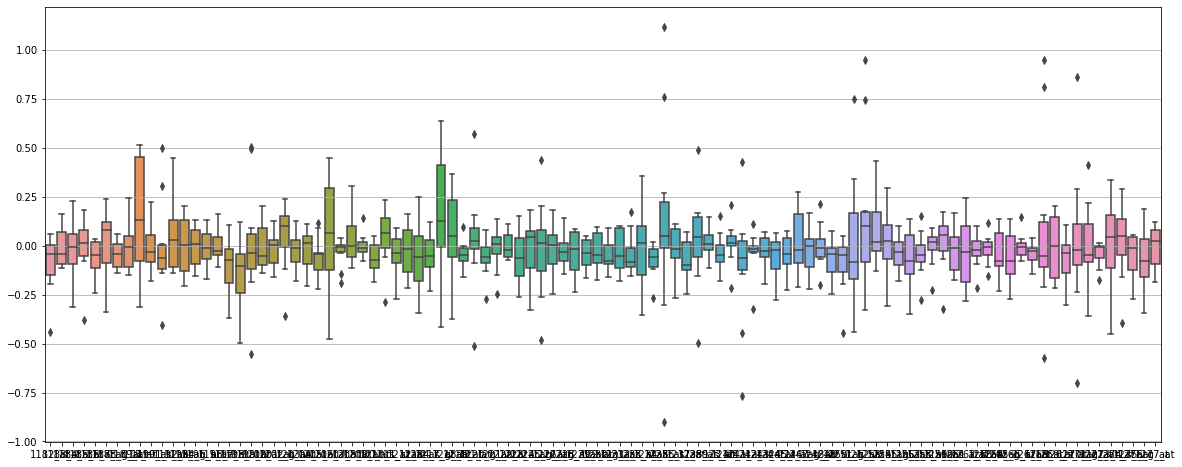

In [ ]:
# Plot human genes
plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=michigan_diff.iloc[:, 200:300])

plt.figure(figsize=(20, 8))
plt.grid()
sns.boxplot(data=irvine_diff.iloc[:, 200:300])

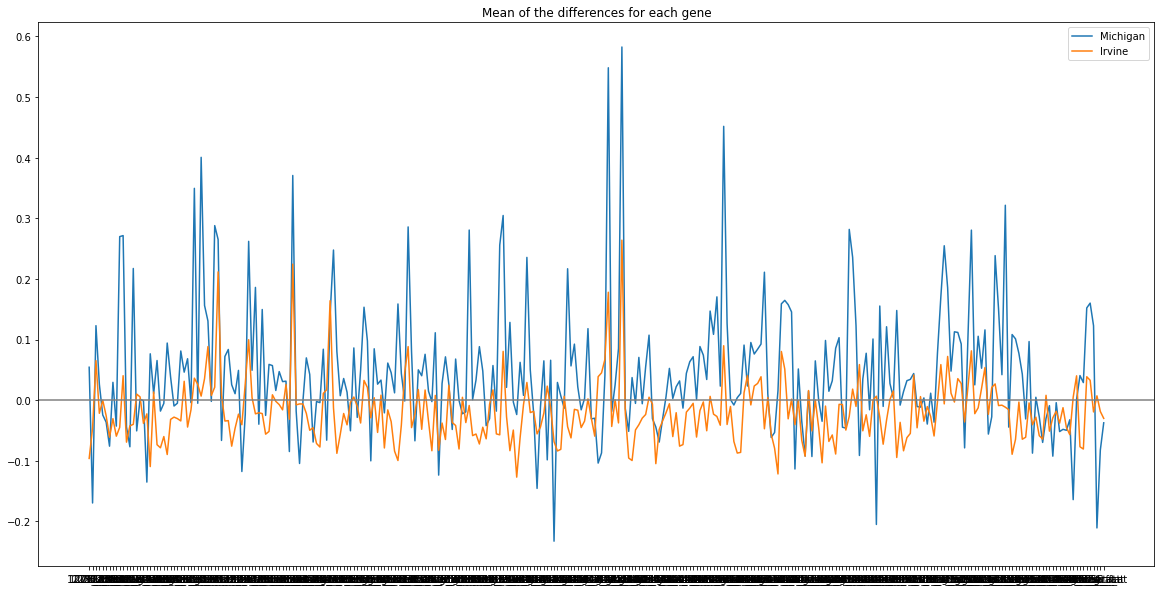

In [11]:
m = michigan_diff.apply(np.mean)
i = irvine_diff.apply(np.mean)

means = pd.DataFrame({'M': m, 'I':i})
plt.figure(figsize=(20, 10))
plt.plot(means.M[300:600], label='Michigan')
plt.plot(means.I[300:600], label='Irvine')
plt.axhline(y=0, color='grey')
plt.title('Mean of the differences for each gene')
plt.legend()

# Hypothesis testing 
Wilcoxon signed-rank test/paired t-test for each gene excluding controls
Tests whether the median of the difference is 0/mean of the difference is 0.  
Wilcoxon signed-rank test: A non-parametric alternative test to the paired t-test. 

## Multiple Hypotheses Testing on the actual data

In [8]:
from scipy.stats import wilcoxon
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

def testing(df, lab, mode):
  
  '''
  do Wilcoxon signed-rank test/paired t-test for each gene. 
  Make either Bonferroni or Benjamini-Hochberg correction when doing the multiple testing

  args:
  -----
  df: data frame without the controls
  lab: should be one of 'michigan', 'irvine', 'davis'
  mode: 'w' if Wilcoxon-signed-rank test, 't' if paired t-test
  '''

  if (mode=='w'):
    p_val = df.apply(wilcoxon).iloc[1,:]

    print(lab)
    print('Wilcoxon signed-rank test')
    print('rejected H0(no correction):{}'.format(sum(p_val<0.05)))

  else:
    p_val = pd.Series([ttest_1samp(df.iloc[:,i], 0)[1] for i in np.arange(df.shape[1])], index=df.columns)

    print(lab)
    print('Paired t-test')
    print('rejected H0(no correction):{}'.format(sum([i<0.05 for i in p_val])))

  # single: stores the rejected genes(individual test) at significance level of 0.05
  single = pd.Series([i<0.05 for i in p_val], index=michigan_diff.columns)
  single = single[single ==True]

  # Update p_val: the genes/p-values that were rejected
  p_val = p_val[p_val.index.isin(single.index)]
 
  # Multiple hypothesis testing: BH at 0.01 level
  bonferr = multipletests(p_val, method='bonferroni')[0]
  bh = multipletests(p_val, method='fdr_bh', alpha=0.01)[0] 

  # Storing
  pvals['_'.join([lab, mode])] = p_val
  rejected['_'.join([lab, mode])+'_b'] = bonferr 
  rejected['_'.join([lab, mode])+'_bh'] = bh  

  print('rejected H0(bonferroni):{}'.format(sum(bonferr)))
  print('rejected H0(BH):{} \n'.format(sum(bh)))
  plt.hist(p_val, bins=np.arange(0, 0.1, 0.01), alpha=0.7, label=lab)
  plt.legend()

michigan
Wilcoxon signed-rank test
rejected H0(no correction):5243
rejected H0(bonferroni):0
rejected H0(BH):2190 

irvine
Wilcoxon signed-rank test
rejected H0(no correction):1181
rejected H0(bonferroni):0
rejected H0(BH):0 



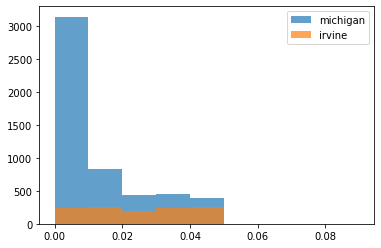

In [9]:
# `pvals` stores the pvalues, `rejected` stores the rejected H0 from the multiple hypothesis testing
pvals = {}
rejected = {}

# Remove controls
michigan_diff = michigan_diff[[c for c in michigan_diff.columns if c not in genes_c.index]]
irvine_diff = irvine_diff[[c for c in irvine_diff.columns if c not in genes_c.index]]

testing(michigan_diff, 'michigan', 'w')
testing(irvine_diff, 'irvine', 'w')

michigan
Paired t-test
rejected H0(no correction):5476
rejected H0(bonferroni):126
rejected H0(BH):2580 

irvine
Paired t-test
rejected H0(no correction):1223
rejected H0(bonferroni):1
rejected H0(BH):0 



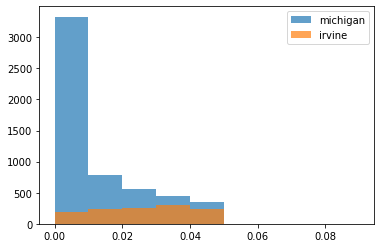

In [10]:
testing(michigan_diff, 'michigan', 't')
testing(irvine_diff, 'irvine', 't')

In [ ]:
print(pvals['irvine_t'].sort_values()[:200])

35005_at    0.000039
1731_at     0.000095
39373_at    0.000095
32273_at    0.000125
37819_at    0.000151
              ...   
37504_at    0.010414
37643_at    0.010432
36243_at    0.010447
33130_at    0.010448
35892_at    0.010493
Length: 200, dtype: float64


# Gene Investigation

In [ ]:
top20_m = pvals['michigan_t'].sort_values().head(20)
pd.concat([genes.loc[top20_m.index], top20_m], axis=1)

,sym,chrom,0
36634_at,BTG2,1,3.279299e-08
38352_at,PPIH,1,4.452885e-08
40258_at,CSNK2A1,20,4.644986e-08
36664_at,GALT,9,4.711366e-08
40084_at,TFCP2,12,1.226897e-07
41696_at,GGCT,7,1.490050e-07
31891_at,CHI3L2,1,2.074171e-07
39602_at,MYRIP,3,2.101828e-07
32629_f_at,BTN3A1,6,2.263375e-07
40266_at,VASH1,14,2.546748e-07


In [ ]:
top20_i = pvals['irvine_t'].sort_values().head(20)
pd.concat([genes.loc[top20_i.index], top20_i], axis=1)

,sym,chrom,0
35005_at,NME6,3,0.000039
1731_at,PDGFRA,4,0.000095
39373_at,FADS1,11,0.000095
32273_at,NaN,NaN,0.000125
37819_at,MDM1,12,0.000151
33883_at,EFS,14,0.000169
39927_at,ARHGAP5,14,0.000240
33375_at,MYO6,6,0.000272
32078_at,NEDD4,15,0.000760
36227_at,IL7R,5,0.000778


In [ ]:
genes.loc[top20_m.index].reset_index().merge(genes.loc[top20_i.index].reset_index(), on='index', how='inner')

,index,sym_x,chrom_x,sym_y,chrom_y


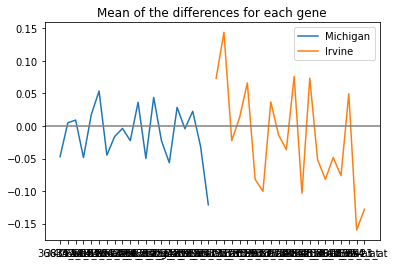

In [ ]:
m = irvine_diff[top20_m.index].apply(np.mean)
i = michigan_diff[top20_i.index].apply(np.mean)

plt.plot(m, label='Michigan')
plt.plot(i, label='Irvine')
plt.axhline(y=0, color='grey')
plt.title('Mean of the differences for each gene')
plt.legend()